In [ ]:
# ! pip install yfinance pandas numpy scipy scikit-learn matplotlib networkx seaborn nbformat

# ASSET PRE-SELECTION


Data Coolection and Asset Pre-selection
> **Goal** - A diverse-, low-correlated and economically meaningful set of assets.



### 1. Overview of Pre-Selection Principles

We start with a universe of 100 assets, primarily with tickers available at Yahoo finance and carefully selected from multiple asset categories including U.S. Equities, International Equities, Emerging Market Equities, REITs, Bonds, Commodities, ETFs, and Cryptocurrencies.

We obtain the daily prices over the past 5 years (to cover both systemic and idiosyncratic risks, while balancing for estimation error and representativeness), and build monthly prices from the daily closing prices via aggregation because not all assets have daily prices (to reduce the noise), and this results in at most 60 data points.

We then apply quality filters on the monthly returns calculated from the monthly prices. The quality filters in this case include history, liquidity, and market capitalization, where applicable. We then estimate the denoised correlation and covariance matrices from the monthly returns, measure the multiple dependencies, and reduce redundancy using clustering and selection algorithms.

Finally, we check the robustness using factor-adjustment, conditional correlation analysis, rolling stability tests, and multiple testing control. The process results in a total of 30 stocks from diverse markets and industries that we use in the portfolio optimization process with Markowitz.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import LedoitWolf
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import networkx as nx
import datetime as dt
import os
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 6)

### 2. Data Preprocessing and Monthly Returns

We start by carefully selecting 100 assets with tickers available on Yahoo finance to represent categories in categories including U.S. Equities, International Equities, Emerging Market Equities, REITs, Bonds, Commodities, ETFs, and Cryptocurrencies.

Here is the summary of the asset categories selected for the universe of 100 assets from which we statistically selected 30 assets for training the Markowitz model:

| Ticker | Company Name | Asset Class | Market / Region | Sector / Industry | Currency |
|--------|--------------|-------------|-----------------|-------------------|----------|
| AAPL | Apple Inc. | Equity | USA | Technology — Consumer Electronics | USD |
| MSFT | Microsoft Corporation | Equity | USA | Technology — Software / Cloud | USD |
| GOOG | Alphabet Inc. (Class C) | Equity | USA | Technology — Internet Services | USD |
| AMZN | Amazon.com, Inc. | Equity | USA | Consumer Discretionary — E-commerce | USD |
| META | Meta Platforms, Inc. | Equity | USA | Communication Services — Social Media | USD |
| NVDA | NVIDIA Corporation | Equity | USA | Technology — Semiconductors | USD |
| TSLA | Tesla, Inc. | Equity | USA | Consumer Discretionary — Automobiles/EV | USD |
| BRK-B | Berkshire Hathaway Inc. (Class B) | Equity | USA | Diversified Conglomerate | USD |
| JPM | JPMorgan Chase & Co. | Equity | USA | Financials — Banking | USD |
| V | Visa Inc. | Equity | USA | Financials — Payments | USD |
| PG | Procter & Gamble Co. | Equity | USA | Consumer Staples — Household Products | USD |
| HD | The Home Depot, Inc. | Equity | USA | Consumer Discretionary — Retail | USD |
| UNH | UnitedHealth Group Inc. | Equity | USA | Healthcare — Insurance / Services | USD |
| MA | Mastercard Incorporated | Equity | USA | Financials — Payments | USD |
| PFE | Pfizer Inc. | Equity | USA | Healthcare — Pharmaceuticals | USD |
| KO | Coca-Cola Co. | Equity | USA | Consumer Staples — Beverages | USD |
| PEP | PepsiCo, Inc. | Equity | USA | Consumer Staples — Food & Beverage | USD |
| DIS | The Walt Disney Company | Equity | USA | Communication Services — Media & Entertainment | USD |
| XOM | Exxon Mobil Corporation | Equity | USA | Energy — Oil & Gas | USD |
| BAC | Bank of America Corporation | Equity | USA | Financials — Banking | USD |
| NFLX | Netflix, Inc. | Equity | USA | Communication Services — Streaming | USD |
| CSCO | Cisco Systems, Inc. | Equity | USA | Technology — Networking | USD |
| INTC | Intel Corporation | Equity | USA | Technology — Semiconductors | USD |
| WMT | Walmart Inc. | Equity | USA | Consumer Staples — Retail | USD |
| CVX | Chevron Corporation | Equity | USA | Energy — Oil & Gas | USD |
| NESN.SW | Nestlé S.A. | Equity | Switzerland | Consumer Staples — Food & Beverage | CHF |
| NOVN.SW | Novartis AG | Equity | Switzerland | Healthcare — Pharmaceuticals | CHF |
| SAP.DE | SAP SE | Equity | Germany | Technology — Enterprise Software | EUR |
| SIE.DE | Siemens AG | Equity | Germany | Industrials — Engineering / Automation | EUR |
| ASML.AS | ASML Holding N.V. | Equity | Netherlands | Technology — Semiconductor equipment | EUR |
| UL | Unilever PLC (ADR/UK listing) | Equity | United Kingdom / NYSE ADR | Consumer Staples — Household Products | USD |
| BP | BP plc | Equity | United Kingdom / NYSE ADR | Energy — Oil & Gas | ADR/ LSE |
| RIO | Rio Tinto Group | Equity | UK / Australia | Materials — Mining | ADR / multiple listings |
| BHP.AX | BHP Group Ltd. | Equity | Australia | Materials — Mining | AUD |
| TM | Toyota Motor Corporation (ADR) | Equity | Japan / ADR | Consumer Discretionary — Automotive | ADR/USD |
| SONY | Sony Group Corporation (ADR) | Equity | Japan / ADR | Communication Services / Electronics | ADR/USD |
| SHOP.TO | Shopify Inc. | Equity | Canada | Technology — E-commerce platform | CAD |
| RY.TO | Royal Bank of Canada | Equity | Canada | Financials — Banking | CAD |
| TD.TO | Toronto-Dominion Bank | Equity | Canada | Financials — Banking | CAD |
| TCS.NS | Tata Consultancy Services Ltd. | Equity | India | Technology — IT Services | INR / ADR |
| INFY.NS | Infosys Ltd. | Equity | India | Technology — IT Services | INR / ADR |
| HDB | HDFC Bank Ltd. (ADR) | Equity | India / ADR | Financials — Banking | ADR |
| BABA | Alibaba Group Holding Ltd. | Equity | China / ADR | Consumer Discretionary — E-commerce & Cloud | ADR |
| PDD | Pinduoduo Inc. | Equity | China | Consumer Discretionary — E-commerce | USD (NASDAQ) |
| VALE | Vale S.A. | Equity | Brazil / ADR | Materials — Mining | ADR on NYSE (USD) |
| ITUB | Itaú Unibanco Holding S.A. | Equity | Brazil / ADR | Financials — Banking | ADR on NYSE |
| MTN.JO | MTN Group Ltd. | Equity | South Africa | Communication Services — Telecom | ZAR listing; OTC/ADR may exist |
| NPSNY | Naspers Ltd. (OTC/ADR) | Equity | South Africa / OTC | Communication Services — Media & Tech investments | OTC ticker (NPSNY) |
| EZA | iShares MSCI South Africa ETF | ETF | USA (NYSE Arca) | Emerging market regional ETF — Africa exposure | USD |
| FM | iShares MSCI Frontier 100 ETF | ETF | USA (NYSE Arca) | Frontier markets proxy — Kenya, Nigeria, Vietnam | USD |
| AMT | American Tower Corp. | REIT | USA | Real Estate — Telecom towers | USD |
| PLD | Prologis, Inc. | REIT | USA | Real Estate — Industrial / Logistics | USD |
| CCI | Crown Castle Inc. | REIT | USA | Real Estate — Communications infrastructure | USD |
| SPG | Simon Property Group | REIT | USA | Real Estate — Retail / Malls | USD |
| O | Realty Income Corporation | REIT | USA | Real Estate — Commercial (monthly dividend) | USD |
| EQIX | Equinix, Inc. | REIT | USA | Real Estate — Data centers | USD |
| WELL | Welltower Inc. | REIT | USA | Real Estate — Healthcare / Senior living | USD |
| PSA | Public Storage | REIT | USA | Real Estate — Self-storage | USD |
| VTR | Ventas, Inc. | REIT | USA | Real Estate — Healthcare real estate | USD |
| DLR | Digital Realty Trust | REIT | USA | Real Estate — Data centers | USD |
| TLT | iShares 20+ Year Treasury Bond ETF | Bond | USA | Fixed Income — Long-term Treasuries | USD |
| IEF | iShares 7–10 Year Treasury Bond ETF | Bond | USA | Fixed Income — Intermediate Treasuries | USD |
| LQD | iShares iBoxx $ Investment Grade Corporate Bond ETF | Bond | USA | Fixed Income — Investment Grade Corporates | USD |
| HYG | iShares iBoxx $ High Yield Corporate Bond ETF | Bond | USA | Fixed Income — High Yield / Junk bonds | USD |
| BND | Vanguard Total Bond Market ETF | Bond | USA | Fixed Income — Broad U.S. bond market | USD |
| AGG | iShares Core U.S. Aggregate Bond ETF | Bond | USA | Fixed Income — Aggregate bonds | USD |
| SHY | iShares 1–3 Year Treasury Bond ETF | Bond | USA | Fixed Income — Short-term Treasuries (cash proxy) | USD |
| EMB | iShares J.P. Morgan USD Emerging Markets Bond ETF | Bond | Global | Fixed Income — USD-denominated EM sovereign bonds | USD |
| GLD | SPDR Gold Shares | Commodity | Global | Commodity — Gold ETF (store of value) | USD |
| SLV | iShares Silver Trust | Commodity | Global | Commodity — Silver ETF | USD |
| USO | United States Oil Fund | Commodity | USA | Commodity — Crude oil futures ETF (tracking caveats) | USD |
| DBA | Invesco DB Agriculture Fund | Commodity | Global | Commodity — Agricultural futures ETF | USD |
| CPER | United States Copper Index Fund | Commodity | Global | Commodity — Copper futures ETF | USD |
| URA | Global X Uranium ETF | Commodity | Global | Commodity — Uranium miners and uranium exposure | USD |
| SPY | SPDR S&P 500 ETF Trust | ETF | USA | Equity ETF — S&P 500 benchmark | USD |
| QQQ | Invesco QQQ Trust | ETF | USA | Equity ETF — Nasdaq-100 (tech bias) | USD |
| DIA | SPDR Dow Jones Industrial Average ETF | ETF | USA | Equity ETF — Dow 30 / blue chips | USD |
| IWM | iShares Russell 2000 ETF | ETF | USA | Equity ETF — U.S. small-cap | USD |
| EFA | iShares MSCI EAFE ETF | ETF | Global | Equity ETF — Developed ex-US | USD |
| EEM | iShares MSCI Emerging Markets ETF | ETF | Global | Equity ETF — Emerging markets | USD |
| XLK | Technology Select Sector SPDR | ETF | USA | Sector ETF — Technology | USD |
| XLF | Financial Select Sector SPDR | ETF | USA | Sector ETF — Financials | USD |
| XLE | Energy Select Sector SPDR | ETF | USA | Sector ETF — Energy | USD |
| XLV | Health Care Select Sector SPDR | ETF | USA | Sector ETF — Healthcare | USD |
| XLY | Consumer Discretionary Select Sector SPDR | ETF | USA | Sector ETF — Consumer Discretionary | USD |
| XLP | Consumer Staples Select Sector SPDR | ETF | USA | Sector ETF — Consumer Staples | USD |
| XLI | Industrial Select Sector SPDR | ETF | USA | Sector ETF — Industrials | USD |
| XLRE | Real Estate Select Sector SPDR | ETF | USA | Sector ETF — Real Estate | USD |
| VNQ | Vanguard Real Estate ETF | ETF | USA | REIT aggregate exposure | USD |
| ARKK | ARK Innovation ETF | ETF | USA | Active thematic ETF — disruptive innovation | USD |
| VTI | Vanguard Total Stock Market ETF | ETF | USA | Broad-market ETF — total U.S. stock market | USD |
| VOO | Vanguard S&P 500 ETF | ETF | USA | ETF — S&P 500 (alternative to SPY) | USD |
| VT | Vanguard Total World Stock ETF | ETF | Global | ETF — global equity (developed + EM) | USD |
| VEA | Vanguard FTSE Developed Markets ETF | ETF | Global | ETF — Developed markets ex-US | USD |
| BTC-USD | Bitcoin | Cryptocurrency | Global | Digital asset — store of value / speculative | USD (exchange feed) |
| ETH-USD | Ethereum | Cryptocurrency | Global | Smart-contract platform / DeFi | USD |
| SOL-USD | Solana | Cryptocurrency | Global | High-throughput smart contracts | USD |
| BNB-USD | Binance Coin | Cryptocurrency | Global | Exchange token / ecosystem asset | USD |
| ADA-USD | Cardano | Cryptocurrency | Global | Smart-contract platform | USD |
| AVAX-USD | Avalanche | Cryptocurrency | Global | Layer-1 blockchain — DeFi / apps | USD |

| Asset Class              | Frequency | Market / Region                        |
|---------------------------|------------|----------------------------------------|
| U.S. Equities             | 25         | United States                          |
| International Equities    | 14         | Europe, Japan, Canada, Australia       |
| Emerging Market Equities  | 11         | India, China, Brazil, Africa           |
| REITs                     | 10         | Primarily U.S.                         |
| Bonds                     | 8          | U.S. and Global                        |
| Commodities               | 6          | Global                                 |
| ETFs                      | 20         | U.S. and Global                        |
| Cryptocurrencies          | 6          | Global                                 |
| **Total**                 | **100**    |                                        |


In [ ]:
us_large_cap = [
    "AAPL", "MSFT", "GOOG", "AMZN", "META", "NVDA", "TSLA", "BRK-B", "JPM", "V",
    "PG", "HD", "UNH", "MA", "PFE", "KO", "PEP", "DIS", "XOM", "BAC",
    "NFLX", "CSCO", "INTC", "WMT", "CVX"
]

intl_equities = [
    "NESN.SW",
    "NOVN.SW",
    "SAP.DE",
    "SIE.DE",
    "ASML.AS",
    "UL",
    "BP",
    "RIO",
    "BHP.AX",
    "TM",
    "SONY",
    "SHOP.TO",
    "RY.TO",
    "TD.TO"
]
em_equities = [
    "TCS.NS",
    "INFY.NS",
    "HDB",
    "BABA",
    "PDD",
    "VALE",
    "ITUB",
    "MTN.JO",
    "NPSNY",
    "EZA",
    "FM"
]

reits = [
    "AMT", "PLD", "CCI", "SPG", "O", "EQIX", "WELL", "PSA", "VTR", "DLR"
]

bonds = [
    "TLT", "IEF", "LQD", "HYG", "BND", "AGG", "SHY", "EMB"
]
commodities = [
    "GLD", "SLV", "USO", "DBA", "CPER", "URA"
]

etfs = [
    "SPY", "QQQ", "DIA", "IWM", "EFA", "EEM", "XLK", "XLF", "XLE", "XLV",
    "XLY", "XLP", "XLI", "XLRE", "VNQ", "ARKK", "VTI", "VOO", "VT", "VEA"
]

# crypto = [
#     "BTC-USD", "ETH-USD", "SOL-USD", "BNB-USD", "ADA-USD", "AVAX-USD"
# ]

ticker_list = (
    us_large_cap +
    intl_equities +
    em_equities +
    reits +
    bonds +
    commodities
    # +
    # etfs +
    # crypto
)
print("Total tickers:", len(ticker_list))


Total tickers: 74


In [ ]:
START_DATE = '2015-01-01'
END_DATE = dt.datetime.today().strftime('%Y-%m-%d')
MIN_MONTHS_HISTORY = 60
MIN_AVG_DAILY_VOLUME = 100_000
FINAL_K = 30
OUT_FOLDER = "asset_preselection_outputs"
os.makedirs(OUT_FOLDER, exist_ok=True)


In [ ]:
def fetch_daily_data(tickers, start, end):
    raw = yf.download(tickers, start=start, end=end, progress=True, group_by='ticker', auto_adjust=False)
    if isinstance(raw.columns, pd.MultiIndex):
        adj = pd.DataFrame({t: raw[(t, 'Adj Close')] if (t, 'Adj Close') in raw.columns else raw[(t, 'Close')] for t in tickers})
        vol = pd.DataFrame({t: raw[(t, 'Volume')] if (t, 'Volume') in raw.columns else np.nan for t in tickers})
    else:
        adj = raw['Adj Close'].to_frame() if 'Adj Close' in raw else raw['Close'].to_frame()
        adj.columns = tickers
        vol = raw['Volume'].to_frame()
        vol.columns = tickers
    adj = adj.dropna(axis=1, how='all')
    vol = vol.reindex(adj.index).fillna(method='ffill')
    return adj, vol
adj_daily, volume_daily = fetch_daily_data(ticker_list, START_DATE, END_DATE)
print("Downloaded price columns:", adj_daily.columns.tolist())

[*********************100%***********************]  74 of 74 completed

Downloaded price columns: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JPM', 'V', 'PG', 'HD', 'UNH', 'MA', 'PFE', 'KO', 'PEP', 'DIS', 'XOM', 'BAC', 'NFLX', 'CSCO', 'INTC', 'WMT', 'CVX', 'NESN.SW', 'NOVN.SW', 'SAP.DE', 'SIE.DE', 'ASML.AS', 'UL', 'BP', 'RIO', 'BHP.AX', 'TM', 'SONY', 'SHOP.TO', 'RY.TO', 'TD.TO', 'TCS.NS', 'INFY.NS', 'HDB', 'BABA', 'PDD', 'VALE', 'ITUB', 'MTN.JO', 'NPSNY', 'EZA', 'FM', 'AMT', 'PLD', 'CCI', 'SPG', 'O', 'EQIX', 'WELL', 'PSA', 'VTR', 'DLR', 'TLT', 'IEF', 'LQD', 'HYG', 'BND', 'AGG', 'SHY', 'EMB', 'GLD', 'SLV', 'USO', 'DBA', 'CPER', 'URA']


In [ ]:
# Computing monthly last price (month-end) and computing monthly returns
adj_monthly = adj_daily.resample('M').last().ffill()

def avg_daily_volume_over_period(volume_df, window_days=252):
    return volume_df.rolling(window=window_days, min_periods=1).mean().iloc[-1]

avg_vol = avg_daily_volume_over_period(volume_daily, window_days=252)
avg_vol = avg_vol.fillna(0)
meta = pd.DataFrame({
    'ticker': adj_monthly.columns,
    'first_date': adj_monthly.notna().idxmax(),
    'last_date': adj_monthly.notna().idxmin(),  # not perfect but we store for reference
    'avg_daily_volume': avg_vol.reindex(adj_monthly.columns).fillna(0).values
}).set_index('ticker')
print(meta.head())

       first_date  last_date  avg_daily_volume
ticker                                        
AAPL   2015-01-31 2015-01-31      5.423634e+07
MSFT   2015-01-31 2015-01-31      2.181625e+07
GOOG   2015-01-31 2015-01-31      2.274766e+07
AMZN   2015-01-31 2015-01-31      4.259865e+07
META   2015-01-31 2015-01-31      1.399656e+07


In [ ]:
# Chistory + liquidity filters
def history_filter(price_monthly_df, min_months=60):
    valid = price_monthly_df.notna().sum(axis=0) >= min_months
    return price_monthly_df.loc[:, valid]

# require at least MIN_MONTHS_HISTORY
adj_monthly_filtered = history_filter(adj_monthly, min_months=MIN_MONTHS_HISTORY)

# liquidity threshold
liquid_tickers = meta.loc[adj_monthly_filtered.columns]['avg_daily_volume'] >= MIN_AVG_DAILY_VOLUME
liquid_tickers = liquid_tickers[liquid_tickers].index.tolist()

# Final tickers after both filters
final_universe_tickers = [t for t in adj_monthly_filtered.columns if t in liquid_tickers]
adj_monthly_filtered = adj_monthly_filtered[final_universe_tickers]

print(f"Universe size after filters: {len(adj_monthly_filtered.columns)}")
print("Tickers:", list(adj_monthly_filtered.columns))

Universe size after filters: 72
Tickers: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JPM', 'V', 'PG', 'HD', 'UNH', 'MA', 'PFE', 'KO', 'PEP', 'DIS', 'XOM', 'BAC', 'NFLX', 'CSCO', 'INTC', 'WMT', 'CVX', 'NESN.SW', 'NOVN.SW', 'SAP.DE', 'SIE.DE', 'ASML.AS', 'UL', 'BP', 'RIO', 'BHP.AX', 'TM', 'SONY', 'SHOP.TO', 'RY.TO', 'TD.TO', 'TCS.NS', 'INFY.NS', 'HDB', 'BABA', 'PDD', 'VALE', 'ITUB', 'MTN.JO', 'EZA', 'AMT', 'PLD', 'CCI', 'SPG', 'O', 'EQIX', 'WELL', 'PSA', 'VTR', 'DLR', 'TLT', 'IEF', 'LQD', 'HYG', 'BND', 'AGG', 'SHY', 'EMB', 'GLD', 'SLV', 'USO', 'DBA', 'CPER', 'URA']


In [ ]:
# monthly log returns (T x N)
returns = np.log(adj_monthly_filtered).diff().dropna()
returns.head()

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,BND,AGG,SHY,EMB,GLD,SLV,USO,DBA,CPER,URA
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-31,0.182673,0.061088,0.000764,0.124308,0.018088,0.137075,0.011737,0.053383,-0.003224,0.073105,...,0.006666,0.005664,0.003462,-0.023465,-0.021613,-0.067967,0.029668,-0.027177,-0.068195,-0.034766
2018-09-30,-0.008337,0.017998,-0.020501,-0.004836,-0.066281,0.001211,-0.130439,0.025496,-0.015302,0.021551,...,-0.005474,-0.006216,-0.001431,0.020106,-0.006629,0.005844,0.053602,-0.008832,0.050156,0.045340
2018-10-31,-0.030952,-0.068387,-0.102899,-0.225887,-0.080169,-0.287373,0.242171,-0.042115,-0.027461,-0.085069,...,-0.008660,-0.006461,0.001530,-0.025470,0.020974,-0.023583,-0.118186,0.029140,-0.052551,-0.102776
2018-11-30,-0.199912,0.041798,0.016268,0.056070,-0.076508,-0.253667,0.038272,0.061221,0.019709,0.029411,...,0.006342,0.007685,0.003803,-0.004897,0.003381,-0.006734,-0.250900,-0.006916,0.043409,0.043184
2018-12-31,-0.124088,-0.087791,-0.055243,-0.118051,-0.070106,-0.202284,-0.051762,-0.066593,-0.130158,-0.071435,...,0.018571,0.019618,0.007570,0.018894,0.048238,0.086260,-0.105050,-0.009806,-0.057902,-0.067382


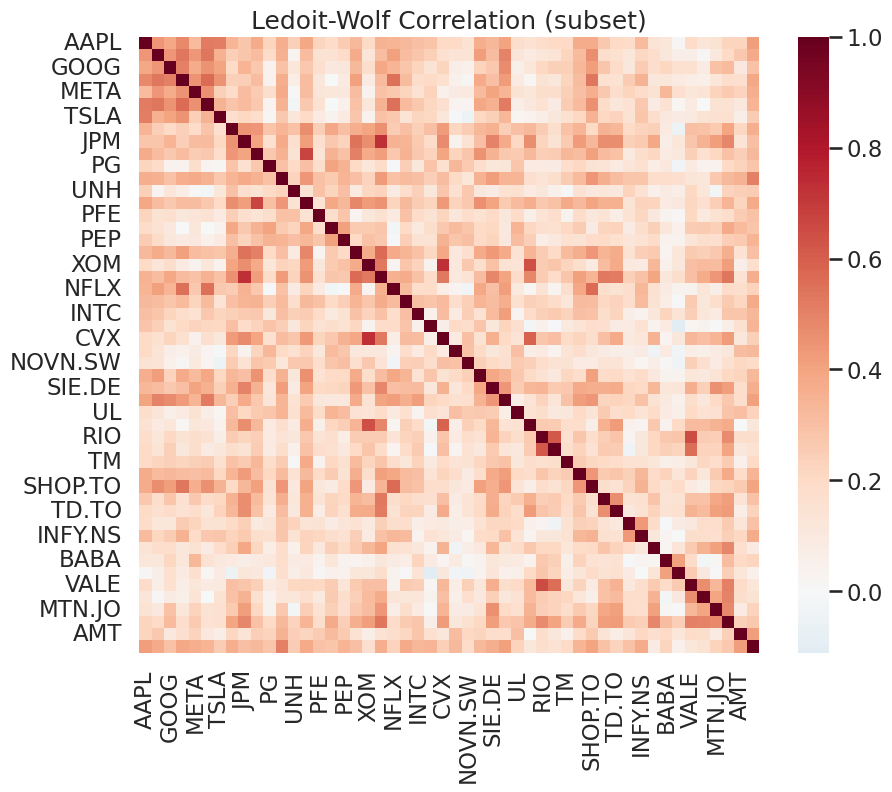

In [ ]:
# Ledoit-Wolf covariance estimator (stable covariance)
lw = LedoitWolf().fit(returns.values)
cov_lw = lw.covariance_
# converting covariance matrix to DataFrame with tickers index/columns
cov_lw_df = pd.DataFrame(cov_lw, index=returns.columns, columns=returns.columns)

# computing correlation matrix from cov
std = np.sqrt(np.diag(cov_lw))
corr_lw = cov_lw / np.outer(std, std)
corr_lw_df = pd.DataFrame(corr_lw, index=returns.columns, columns=returns.columns)

# quick heatmap check
plt.figure(figsize=(10,8))
sns.heatmap(corr_lw_df.iloc[:50, :50], cmap='RdBu_r', center=0)
plt.title('Ledoit-Wolf Correlation (subset)')
plt.show()

In [ ]:
corr_lw_df

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,BND,AGG,SHY,EMB,GLD,SLV,USO,DBA,CPER,URA
AAPL,1.000000,0.439027,0.386504,0.478739,0.318170,0.516996,0.511396,0.336684,0.278876,0.372641,...,0.123654,0.114094,0.012129,0.266258,0.071295,0.224091,0.164137,0.062484,0.158058,0.179998
MSFT,0.439027,1.000000,0.444263,0.532672,0.438666,0.538428,0.355657,0.245082,0.282169,0.311685,...,0.137119,0.129407,0.020738,0.259055,0.053447,0.170423,0.063530,0.025209,0.159986,0.304334
GOOG,0.386504,0.444263,1.000000,0.509506,0.374142,0.451715,0.399877,0.200037,0.342373,0.270339,...,0.116236,0.106121,0.013067,0.272771,0.123038,0.306946,0.162566,0.123863,0.276058,0.361111
AMZN,0.478739,0.532672,0.509506,1.000000,0.452747,0.563459,0.450277,0.239792,0.244826,0.311492,...,0.140260,0.130394,0.020819,0.225843,0.069847,0.136031,-0.043316,0.043547,0.152364,0.361747
META,0.318170,0.438666,0.374142,0.452747,1.000000,0.459926,0.243857,0.196618,0.306574,0.253952,...,0.125348,0.114895,0.021043,0.332986,0.081851,0.158778,0.107275,0.099478,0.217434,0.209740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLV,0.224091,0.170423,0.306946,0.136031,0.158778,0.156651,0.156707,0.222574,0.174577,0.164700,...,0.116092,0.108568,0.018867,0.294864,0.457079,1.000000,0.202606,0.121012,0.351181,0.275617
USO,0.164137,0.063530,0.162566,-0.043316,0.107275,0.165435,0.013970,0.257104,0.365964,0.258826,...,-0.039124,-0.045774,-0.039705,0.228256,-0.079864,0.202606,1.000000,0.222972,0.261158,0.141609
DBA,0.062484,0.025209,0.123863,0.043547,0.099478,0.042764,0.064126,0.228412,0.202649,0.119063,...,-0.005670,-0.008886,-0.006748,0.107669,0.036492,0.121012,0.222972,1.000000,0.204983,0.173578
CPER,0.158058,0.159986,0.276058,0.152364,0.217434,0.220413,0.149044,0.307370,0.327566,0.256260,...,0.073748,0.063330,0.001399,0.262885,0.188690,0.351181,0.261158,0.204983,1.000000,0.338548


In [ ]:
# Spearman correlation (rank-based)
corr_spearman = returns.corr(method='spearman')

# distance correlation- function + pairwise matrix
def distance_covariance(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    a = np.abs(x[:, None] - x[None, :])
    b = np.abs(y[:, None] - y[None, :])
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    return np.sqrt(np.sum(A * B) / (n * n))

def distance_corr(x, y):
    dxy = distance_covariance(x, y)
    dxx = distance_covariance(x, x)
    dyy = distance_covariance(y, y)
    if dxx * dyy == 0:
        return 0.0
    return dxy / np.sqrt(dxx * dyy)

# pairwise distance correlation matrix
def pairwise_distance_corr(returns_df):
    cols = returns_df.columns.tolist()
    n = len(cols)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dc = distance_corr(returns_df.iloc[:, i].values, returns_df.iloc[:, j].values)
            mat[i, j] = dc
            mat[j, i] = dc
    return pd.DataFrame(mat, index=cols, columns=cols)

dist_corr_df = pairwise_distance_corr(returns)
dist_corr_df.head()

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,BND,AGG,SHY,EMB,GLD,SLV,USO,DBA,CPER,URA
AAPL,1.000000,0.595888,0.476262,0.550472,0.457859,0.567045,0.564292,0.419564,0.371025,0.475182,...,0.391102,0.370420,0.181938,0.518259,0.179416,0.256821,0.268174,0.157395,0.249691,0.248034
MSFT,0.595888,1.000000,0.580206,0.685745,0.584327,0.641673,0.420625,0.374864,0.408605,0.464739,...,0.392553,0.376823,0.256739,0.502377,0.150869,0.241556,0.236909,0.182084,0.274292,0.355081
GOOG,0.476262,0.580206,1.000000,0.588978,0.476907,0.500964,0.401557,0.321044,0.447126,0.383508,...,0.323511,0.305634,0.206697,0.456269,0.213464,0.360363,0.286722,0.215293,0.388408,0.460079
AMZN,0.550472,0.685745,0.588978,1.000000,0.566409,0.583584,0.487171,0.298479,0.338289,0.417343,...,0.344490,0.332678,0.227235,0.427962,0.162966,0.185450,0.241083,0.199224,0.220394,0.408245
META,0.457859,0.584327,0.476907,0.566409,1.000000,0.562978,0.288610,0.326941,0.489063,0.402188,...,0.330377,0.304761,0.220423,0.521461,0.205860,0.238162,0.258116,0.240689,0.308238,0.320744


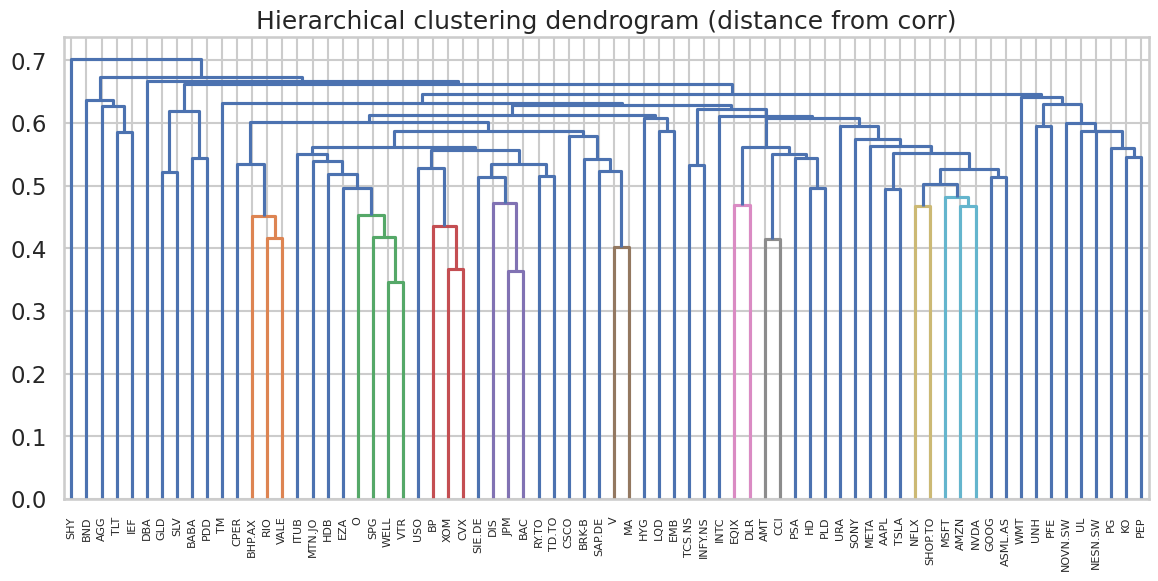

In [ ]:
# hierarchical clustering on Pearson (Ledoit-Wolf) correlation
# converting correlations to distance metric for clustering
corr = corr_lw_df.copy()
corr = corr.clip(-0.9999, 0.9999)  # safety for sqrt
dist_matrix = np.sqrt((1 - corr) / 2)  # standard distance transform

# convert to condensed distance vector (required by linkage)
condensed = squareform(dist_matrix.values, checks=False)
Z = linkage(condensed, method='average')  # 'average' is robust (Ward also works on Euclidean)

# plot dendrogram for visual inspection (useful for smaller N)
plt.figure(figsize=(14, 6))
dendrogram(Z, labels=returns.columns.tolist(), leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical clustering dendrogram (distance from corr)')
plt.show()

### Category 1 Assets/Tickers

In [ ]:
# greedy selection which iteratively picks the asset with minimal average corr to already selected set
def greedy_min_avg_corr(corr_df, k=30):
    names = corr_df.columns.tolist()
    selected = []
    avg_corr = corr_df.mean(axis=1)
    first = avg_corr.idxmin()
    selected.append(first)
    while len(selected) < k:
        candidates = [n for n in names if n not in selected]
        # computing average correlation to the selected set for each candidate
        scores = {c: corr_df.loc[c, selected].mean() for c in candidates}
        # picking candidate with minimal average correlation to selected
        next_one = min(scores, key=scores.get)
        selected.append(next_one)
    return selected

k = min(FINAL_K, len(returns.columns))
greedy_selected = greedy_min_avg_corr(corr_lw_df, k=k)
print("Greedy selection count:", len(greedy_selected))
print(greedy_selected)

Greedy selection count: 30
['SHY', 'USO', 'DLR', 'UNH', 'IEF', 'PDD', 'DBA', 'WMT', 'AGG', 'MTN.JO', 'BND', 'NOVN.SW', 'GLD', 'TSLA', 'TCS.NS', 'BP', 'TLT', 'NESN.SW', 'TM', 'BABA', 'PFE', 'NFLX', 'HDB', 'PG', 'BHP.AX', 'INFY.NS', 'XOM', 'ITUB', 'NVDA', 'PSA']


### Category 2 Assets/Tickers

In [ ]:
# generating cluster labels and pick representative(s)
n_clusters = min(FINAL_K, max(2, len(returns.columns)//2))
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
cluster_df = pd.DataFrame({'ticker': returns.columns, 'cluster': clusters}).set_index('ticker')

# helper to pick representative per cluster: lowest mean intra-cluster correlation, tiebreak by liquidity
def pick_cluster_representatives(corr_df, meta_df, per_cluster=1):
    reps = []
    for c in sorted(cluster_df['cluster'].unique()):
        members = cluster_df[cluster_df['cluster'] == c].index.tolist()
        sub_corr = corr_df.loc[members, members]
        mean_intra = sub_corr.mean(axis=1)
        ranked = mean_intra.sort_values().index.tolist()  # low mean_intra = less correlated to own cluster
        # tiebreak by liquidity if meta available
        if per_cluster == 1:
            reps.append(ranked[0])
        else:
            picks = ranked[:min(per_cluster, len(ranked))]
            reps.extend(picks)
    return reps

cluster_reps = pick_cluster_representatives(corr_lw_df, meta, per_cluster=1)
print("Cluster reps count:", len(cluster_reps))
print(cluster_reps)

Cluster reps count: 30
['TLT', 'IEF', 'AGG', 'BND', 'GLD', 'BABA', 'CPER', 'ITUB', 'BRK-B', 'CSCO', 'LQD', 'EMB', 'HYG', 'INFY.NS', 'PSA', 'TSLA', 'META', 'SONY', 'URA', 'INTC', 'TM', 'UNH', 'PFE', 'PG', 'NESN.SW', 'UL', 'NOVN.SW', 'WMT', 'DBA', 'SHY']


### Correlation for the Union of Category 1 and 2 Assets

> The correlation of All Assets that are in Category 1, 2 or both

In [ ]:
# Heatmap
selected_union = list(set(cluster_reps) | set(greedy_selected))
subset = corr_lw_df.loc[selected_union, selected_union].copy()
subset

,PFE,CSCO,TM,LQD,BP,USO,TSLA,NFLX,AGG,HDB,...,PSA,META,GLD,NVDA,UNH,ITUB,DBA,CPER,INTC,SHY
PFE,1.000000,0.295775,0.036641,0.130107,0.059108,-0.064961,0.091013,0.093566,0.069658,0.103595,...,0.075195,0.129619,0.087063,0.153475,0.291423,0.100961,0.096302,0.127419,0.188735,0.009010
CSCO,0.295775,1.000000,0.121805,0.152964,0.242584,0.165839,0.138670,0.319859,0.066743,0.151882,...,0.207592,0.224124,0.023753,0.316913,0.181047,0.117773,0.061098,0.227911,0.303207,0.008038
TM,0.036641,0.121805,1.000000,0.108485,0.183109,0.171527,0.166137,0.178885,0.038663,0.119640,...,0.103528,0.239933,0.019408,0.253086,0.010019,0.210094,0.146963,0.102538,0.228172,0.004307
LQD,0.130107,0.152964,0.108485,1.000000,0.086744,0.051921,0.146413,0.246300,0.201967,0.207492,...,0.200463,0.224754,0.155797,0.240118,0.073307,0.155975,0.022699,0.165518,0.211920,0.045775
BP,0.059108,0.242584,0.183109,0.086744,1.000000,0.523406,0.041057,0.020534,-0.005128,0.270836,...,0.001815,0.118924,-0.104884,0.101675,0.094770,0.319718,0.215522,0.306411,0.195411,-0.021387
USO,-0.064961,0.165839,0.171527,0.051921,0.523406,1.000000,0.013970,-0.035564,-0.045774,0.201233,...,0.079904,0.107275,-0.079864,0.165435,0.024601,0.327540,0.222972,0.261158,0.046121,-0.039705
TSLA,0.091013,0.138670,0.166137,0.146413,0.041057,0.013970,1.000000,0.274663,0.063243,0.179799,...,0.170423,0.243857,0.056736,0.344918,0.120567,0.142575,0.064126,0.149044,0.219418,-0.008096
NFLX,0.093566,0.319859,0.178885,0.246300,0.020534,-0.035564,0.274663,1.000000,0.142010,0.158234,...,0.135548,0.269518,0.073203,0.549863,0.082382,0.130159,0.019675,0.170466,0.179921,0.034936
AGG,0.069658,0.066743,0.038663,0.201967,-0.005128,-0.045774,0.063243,0.142010,1.000000,0.091763,...,0.140980,0.114895,0.110669,0.125892,0.034435,0.046523,-0.008886,0.063330,0.141900,0.041047
HDB,0.103595,0.151882,0.119640,0.207492,0.270836,0.201233,0.179799,0.158234,0.091763,1.000000,...,0.119721,0.143024,0.005548,0.086394,0.049569,0.347396,0.122652,0.260560,0.115905,0.003017


In [ ]:
corr = subset.copy()
np.fill_diagonal(corr.values, np.nan)
corr_unstacked = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).unstack()
corr_unstacked = corr_unstacked.dropna()
max_corr_pair = corr_unstacked.idxmax()
min_corr_pair = corr_unstacked.idxmin()
max_corr_value = corr_unstacked.max()
min_corr_value = corr_unstacked.min()
print(f"🔹 Highest correlation: {max_corr_value:.4f} between {max_corr_pair[0]} and {max_corr_pair[1]}")
print(f"🔹 Lowest  correlation: {min_corr_value:.4f} between {min_corr_pair[0]} and {min_corr_pair[1]}")


🔹 Highest correlation: 0.6481 between XOM and BP
🔹 Lowest  correlation: -0.2138 between DLR and USO


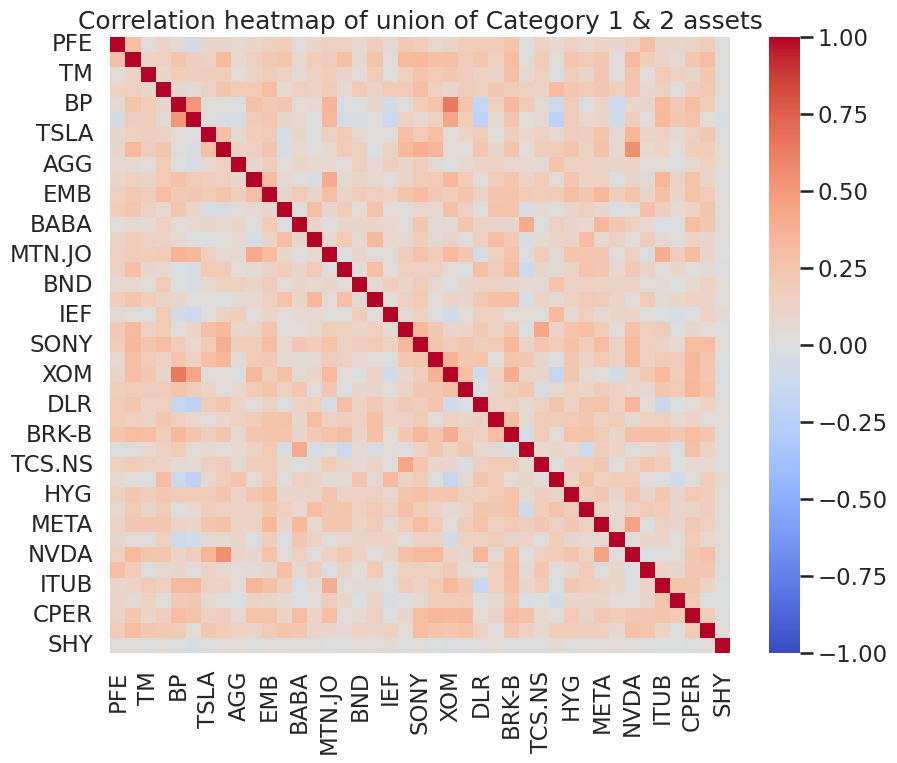

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=False)
plt.title('Correlation heatmap of union of Category 1 & 2 assets')
plt.show()

### Conditional correlations

In [ ]:
# PARAMETERS
market_ticker = 'SPY' # Benchmark Index
quantile_p = 0.10
n_boot = 2000
random_state = 42

# Sanity check inputs exist
for name in ['returns', 'corr_lw_df', 'greedy_selected', 'cluster_reps']:
    if name not in globals():
        raise NameError(f"Required variable '{name}' is not defined in the environment.")

# Ensure returns index is datetime-like (for resampling / selection safety)
returns.index = pd.to_datetime(returns.index)

# Helper utilities -
def upper_triangle_values_mean(corr_df):
    """Return mean of unique off-diagonal correlation values (upper triangle k=1)."""
    if corr_df.shape[0] < 2:
        return np.nan
    mat = corr_df.values
    iu = np.triu_indices_from(mat, k=1)
    vals = mat[iu]
    return float(np.nanmean(vals))

def bootstrap_avg_corr(returns_sub, months_idx, n_boot=1000, rng=None):
    """
    Bootstrap average off-diagonal correlation by resampling months (with replacement).
    returns_sub : DataFrame of returns (columns = tickers)
    months_idx    : sequence of timestamps (index values) to sample from
    """
    if rng is None:
        rng = np.random.default_rng(random_state)
    months = list(months_idx)
    if len(months) == 0:
        return np.array([]), (np.nan, np.nan)
    res = []
    pbar = None
    for _ in range(n_boot):
        samp_months = rng.choice(months, size=len(months), replace=True)
        try:
            R = returns_sub.loc[samp_months].dropna(axis=1, how='all')
        except Exception:
            # if indices don't align exactly, reindex
            R = returns_sub.reindex(samp_months).dropna(axis=1, how='all')
        if R.shape[1] < 2:
            res.append(np.nan)
            continue
        corr = R.corr()
        res.append(upper_triangle_values_mean(corr))
    arr = np.array(res, dtype=float)
    lower, upper = np.nanpercentile(arr, [2.5, 97.5])
    return arr, (lower, upper)

# Identifying crisis months (bottom decile of market returns)
if market_ticker not in returns.columns:
    raise KeyError(f"Market ticker '{market_ticker}' not found in returns.columns")

market_returns = returns[market_ticker].dropna()
threshold = market_returns.quantile(quantile_p)
crisis_idx = market_returns[market_returns <= threshold].index
T_c = len(crisis_idx)
print(f"Number of crisis months (bottom {int(quantile_p*100)}%): {T_c}")

# Preparing Category lists and check presence in returns/corr matrices
cat1 = [t for t in greedy_selected if t in returns.columns]      # Category 1 (greedy)
cat2 = [t for t in cluster_reps if t in returns.columns]         # Category 2 (clusters)

missing_cat1 = sorted(set(greedy_selected) - set(cat1))
missing_cat2 = sorted(set(cluster_reps) - set(cat2))
if missing_cat1:
    print(f"Warning: {len(missing_cat1)} greedy_selected tickers missing from returns and will be ignored: {missing_cat1}")
if missing_cat2:
    print(f"Warning: {len(missing_cat2)} cluster_reps tickers missing from returns and will be ignored: {missing_cat2}")

# --- Utility to compute summary for a given list of tickers ---
def compute_category_summary(tickers, label):
    out = {'label': label, 'n_assets': len(tickers)}
    if len(tickers) < 2:
        out.update({
            'avg_full_offdiag': np.nan,
            'avg_crisis_offdiag': np.nan,
            'delta_crisis_minus_full': np.nan,
            'full_ci_lower': np.nan, 'full_ci_upper': np.nan,
            'crisis_ci_lower': np.nan, 'crisis_ci_upper': np.nan
        })
        return out

    # Full-sample correlation (Ledoit-Wolf) -- use corr_lw_df if it contains tickers
    if not set(tickers).issubset(set(corr_lw_df.index)):
        # If corr_lw_df doesn't include some tickers, fallback to sample corr computed on full returns
        corr_full = returns[tickers].dropna(axis=1, how='all').corr()
    else:
        corr_full = corr_lw_df.loc[tickers, tickers]

    avg_full = upper_triangle_values_mean(corr_full)

    # Crisis correlation (sample on crisis months)
    R_crisis = returns.loc[crisis_idx, tickers].dropna(axis=1, how='all')
    if R_crisis.shape[1] < 2 or R_crisis.shape[0] == 0:
        avg_crisis = np.nan
    else:
        corr_crisis = R_crisis.corr()
        avg_crisis = upper_triangle_values_mean(corr_crisis)

    # Bootstrapped CIs (months-level bootstrap)
    # Full-sample bootstrap: resampling from full sample months
    full_arr, (full_lo, full_hi) = bootstrap_avg_corr(returns[tickers], returns.index, n_boot=n_boot)
    crisis_arr, (crisis_lo, crisis_hi) = bootstrap_avg_corr(returns[tickers], crisis_idx, n_boot=n_boot)

    out.update({
        'avg_full_offdiag': avg_full,
        'avg_crisis_offdiag': avg_crisis,
        'delta_crisis_minus_full': (avg_crisis - avg_full) if (avg_crisis is not None and avg_full is not None) else np.nan,
        'full_boot_mean': np.nanmean(full_arr),
        'full_ci_lower': full_lo, 'full_ci_upper': full_hi,
        'crisis_boot_mean': np.nanmean(crisis_arr),
        'crisis_ci_lower': crisis_lo, 'crisis_ci_upper': crisis_hi
    })
    return out

# summaries
summary_cat1 = compute_category_summary(cat1, 'Category1_greedy')
summary_cat2 = compute_category_summary(cat2, 'Category2_cluster')

summary_df = pd.DataFrame([summary_cat1, summary_cat2]).set_index('label')

# Intersection
intersection = sorted(set(cat1).intersection(set(cat2)))
summary_df['n_intersection'] = len(intersection)

#summary
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n=== Summary Table ===")
print(summary_df[['n_assets','avg_full_offdiag','avg_crisis_offdiag','delta_crisis_minus_full',
                  'full_ci_lower','full_ci_upper','crisis_ci_lower','crisis_ci_upper','n_intersection']])

print("\nTickers common to both selections (intersection):")
print(intersection)


KeyError: "Market ticker 'SPY' not found in returns.columns"

**Number of crisis months (bottom 10%):** 7

### Summary Table

| Label | n_assets | avg_full_offdiag | avg_crisis_offdiag | delta_crisis_minus_full | full_ci_lower | full_ci_upper | crisis_ci_lower | crisis_ci_upper | n_intersection |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| Category1_greedy | 30 | 0.0841 | 0.0983 | 0.0142 | 0.1007 | 0.1908 | 0.0024 | 0.1854 | 18 |
| Category2_cluster | 30 | 0.1338 | 0.2348 | 0.1011 | 0.2056 | 0.3364 | 0.0801 | 0.3526 | 18 |

In [ ]:
# Identifying and displaying crisis months (bottom decile of SPY returns)
market_ticker = 'SPY'
quantile_p = 0.10

if market_ticker not in returns.columns:
    raise KeyError(f"Market ticker '{market_ticker}' not found in returns.columns")

# Extract and clean market returns
market_returns = returns[market_ticker].dropna()

# Compute threshold for bottom decile
threshold = market_returns.quantile(quantile_p)

# Identify crisis months (bottom 10% of returns)
crisis_idx = market_returns[market_returns <= threshold].index
T_c = len(crisis_idx)

print(f"\nNumber of crisis months (bottom {int(quantile_p*100)}%): {T_c}")

# Display the months and returns neatly (sorted from worst to best)
crisis_months = market_returns.loc[crisis_idx].sort_values()
print("\n=== Crisis Months (Bottom 10% of Market Returns) ===")
for date, ret in crisis_months.items():
    print(f"{date.strftime('%B %Y')}: {ret:.4%}")

# Optional: store for further analysis
crisis_summary = pd.DataFrame({
    'Month_Year': [d.strftime('%B %Y') for d in crisis_months.index],
    'Return': crisis_months.values
}).reset_index(drop=True)

**Number of crisis months (bottom 10%):** 7

### Crisis Months (Bottom 10% of Market Returns)

| Month | Return |
| :--- | :--- |
| September 2022 | -9.7002% |
| April 2022 | -9.1862% |
| June 2022 | -8.6060% |
| December 2022 | -5.9356% |
| March 2025 | -5.7332% |
| January 2022 | -5.4183% |

### Final Assets/Tickers

In [ ]:
all_tickers = sorted(set(cluster_reps + greedy_selected))

# Build DataFrame
comparison_df = pd.DataFrame({
    'Ticker': all_tickers,
    'Selected_by_Cluster': [ticker in cluster_reps for ticker in all_tickers],
    'Selected_by_Greedy': [ticker in greedy_selected for ticker in all_tickers]
})

# Add final column: True if selected by both
comparison_df['Both_Selected'] = comparison_df['Selected_by_Cluster'] & comparison_df['Selected_by_Greedy']

print(comparison_df)

| Ticker | Selected by Cluster | Selected by Greedy | Both Selected |
| :--- | :--- | :--- | :--- |
| AGG | True | True | True |
| AVAX-USD | False | True | False |
| BABA | False | True | False |
| BHP.AX | False | True | False |
| BNB-USD | True | True | True |
| BND | True | True | True |
| BP | False | True | False |
| BRK-B | True | False | False |
| CPER | True | False | False |
| DBA | True | True | True |
| EEM | True | False | False |
| EMB | True | False | False |
| GLD | True | True | True |
| HDB | True | True | True |
| HYG | True | False | False |
| IEF | True | True | True |
| INFY.NS | False | True | False |
| INTC | True | False | False |
| ITUB | True | True | True |
| LQD | True | False | False |
| META | True | True | True |
| NESN.SW | True | True | True |
| NFLX | False | True | False |
| NOVN.SW | True | False | False |
| PDD | False | True | False |
| PEP | True | True | True |
| PFE | True | True | True |
| PG | False | True | False |
| RY.TO | True | False | False |
| SAP.DE | True | False | False |
| SHY | True | True | True |
| SLV | False | True | False |
| SOL-USD | False | True | False |
| TCS.NS | True | True | True |
| TM | True | True | True |
| TSLA | False | True | False |
| UL | True | False | False |
| UNH | False | True | False |
| URA | True | False | False |
| USO | True | True | True |
| WMT | True | True | True |
| XLV | True | False | False |
| XOM | False | True | False |

In [ ]:
# Intersection of both sets
final_selected_both = list(set(cluster_reps) & set(greedy_selected))

print(final_selected_both)

['PFE', 'TM', 'TSLA', 'AGG', 'NOVN.SW', 'BABA', 'NESN.SW', 'WMT', 'BND', 'PG', 'IEF', 'INFY.NS', 'TLT', 'PSA', 'GLD', 'UNH', 'DBA', 'ITUB', 'SHY']


In [ ]:
len(final_selected_both)

19

| Ticker | Company / Asset Name | Asset Class | Market / Region | Description / Rationale |
| :--- | :--- | :--- | :--- | :--- |
| WMT | Walmart Inc. | Equity | U.S. | Global retail giant providing exposure to the consumer staples and defensive retail sectors. |
| TM | Toyota Motor Corporation | Equity | Japan | Major global automobile manufacturer, representing the automotive and industrial sectors. |
| PFE | Pfizer Inc. | Equity | U.S. | Leading global pharmaceutical company, providing healthcare sector exposure and defensive stability. |
| SHY | iShares 1–3 Year Treasury Bond ETF | Bond | U.S. | Short-term Treasury exposure serving as a low-risk, risk-free proxy component. |
| HDB | HDFC Bank Ltd. | Equity | India | Major Indian private bank, offering exposure to emerging market financial growth. |
| DBA | Invesco DB Agriculture Fund | Commodity | Global | Diversified agricultural commodity exposure, useful as an inflation hedge. |
| UNH | UnitedHealth Group Incorporated | Equity | U.S. | Leading U.S. healthcare provider, offering defensive exposure to the health insurance sector. |
| PEP | PepsiCo Inc. | Equity | U.S. | Global consumer staples company, providing stable earnings and defensive sector exposure. |
| BND | Vanguard Total Bond Market ETF | Bond | U.S. | Comprehensive exposure to the U.S. investment-grade bond market. |
| META | Meta Platforms Inc. (Facebook) | Equity | U.S. | Large-cap technology and communication services company, offering exposure to digital advertising and AI innovation. |
| NESN.SW | Nestlé S.A. | Equity | Switzerland | Global consumer goods conglomerate, offering diversification through international consumer staples. |
| ITUB | Itaú Unibanco Holding S.A. | Equity | Brazil | Leading Latin American financial institution, offering exposure to Brazil's banking sector. |
| BNB-USD | Binance Coin | Cryptocurrency | Global | Native cryptocurrency of the Binance exchange ecosystem, offering frontier digital asset exposure. |
| AGG | iShares Core U.S. Aggregate Bond ETF | Bond | U.S. | Benchmark ETF tracking the total U.S. investment-grade bond market, enhancing fixed-income stability. |
| USO | United States Oil Fund LP | Commodity | U.S. | Tracks crude oil futures, providing direct exposure to the energy commodity market. |
| TCS.NS | Tata Consultancy Services Ltd. | Equity | India | Leading global IT services firm, providing emerging market technology exposure. |
| IEF | iShares 7–10 Year Treasury Bond ETF | Bond | U.S. | Intermediate-term Treasury bond ETF, balancing yield and duration risk. |
| GLD | SPDR Gold Shares | Commodity | Global | Gold-backed ETF, serving as a store of value and a hedge against inflation and market uncertainty. |

| Asset Class | Count | Market / Region | Representative Assets |
| :--- | :--- | :--- | :--- |
| Equities | 9 | U.S., Switzerland, India, Brazil, Japan | WMT, TM, PFE, UNH, PEP, META, NESN.SW, TCS.NS, ITUB |
| Bonds / Fixed Income ETFs | 4 | U.S. | SHY, IEF, AGG, BND |
| Commodities | 3 | Global / U.S. | GLD, USO, DBA |
| Cryptocurrency | 1 | Global | BNB-USD |
| **Total** | **18** | — | — |